<a href="https://colab.research.google.com/github/Argand7i/Image-Classification-ResNet/blob/main/COVID_19_Classifier_(GithHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#General libraries
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import numpy as np

from tensorflow.keras import layers
from sklearn.metrics import classification_report,confusion_matrix

#Skimage
import skimage.io as io
from skimage.transform import  rescale,resize
from skimage import exposure
from skimage.util import img_as_uint,img_as_ubyte
from skimage.color import rgb2gray

#Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


#Bayesian Optimization
!pip install bayesian-optimization
!pip install gpy
!pip install gpyopt
import GPy, GPyOpt

%matplotlib inline

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=2102a6e74890577ebbcff9d81ef4a04fcb07b3c9f5ea7ee9c83a5ff11d9105ca
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
     |████████████████████████████████| 959 kB 10.7 MB/s 
     |████████████████████████████████| 71 kB 10.1 MB/s 
  Created wheel for gpy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565085 sha256=b8de189ddc8519e5fc0f6ed745bcbebc6a5711d2d8523b888b3e06cd28648dd6
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=1f839efa28a6a387f903e7381158cc920d89b0b15030d8279fdccb1be3745d6b
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built gpy paramz
    

# **Loading Data**

In [ ]:
#Google Drive Permissions
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#==================================
#LOADING PROCESSED TRAINING DATA 
#==================================

labels = ['Covid', 'Normal','Pneumonia']
img_size = 224  
def get_data(data_dir): 
    data = [] 
    for label in labels: 
        path = os.path.join('/content/drive/MyDrive/Data/Processeddata/Trainingset', label) #YOUR DATA PATH
        class_num = labels.index(label)
        for img in os.listdir(path): 
            try:
                img_arr = io.imread(os.path.join(path, img))
                img_gray = rgb2gray(img_arr) 
                data.append([img_gray, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
#==================================
#LOADING PROCESSED VALIDATION DATA 
#==================================

labels = ['Covid', 'Normal','Pneumonia']
img_size = 224  
def get_dataval(data_dir): 
    data = [] 
    for label in labels: 
        path = os.path.join('/content/drive/MyDrive/Data/Processeddata/Validationset', label) #YOUR DATA PATH
        class_num = labels.index(label)
        for img in os.listdir(path): 
            try:
                img_arr = io.imread(os.path.join(path, img))
                img_gray = rgb2gray(img_arr) 
                data.append([img_gray, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
#==================================
#LOADING PROCESSED TEST DATA
#==================================
labels = ['Covid', 'Normal','Pneumonia']
img_size = 224  #Por definir 
def get_datatest(data_dir): 
    data = [] 
    for label in labels: 
        path = os.path.join('/content/drive/MyDrive/Data/Processeddata/TestSet', label) #YOUR DATA PATH
        class_num = labels.index(label)
        for img in os.listdir(path): 
            try:
                img_arr = io.imread(os.path.join(path, img))
                img_gray = rgb2gray(img_arr) 
                data.append([img_gray, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
#Training set loading
train= get_data('/content/drive/MyDrive/Data/Processeddata/Trainingset') #Tomamos nuestro set de entrenamiento del directorio

In [ ]:
#Validation set loading
val= get_dataval('/content/drive/MyDrive/Data/Processeddata/Validationset')

In [ ]:
#Test set loading
test= get_datatest('/content/drive/MyDrive/Data/Processeddata/TestSet')

# Exploratory Data Analisys



In [ ]:
#==================================
#SETS VISUALISATION
#==================================
l=[]
for i in train:  #train, val or test
  if (i[1]==0):
    l.append("Covid")
  
  elif (i[1]==1):
    l.append("Normal")
  else:
    l.append("Pneumonia")

sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.countplot(l)

In [ ]:
#==================================================
#IMAGES AND THEIR LABELS IN THE TRAINING DATA SET
#==================================================

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data/Processeddata/Trainingset")
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#0 -> Covid
#1 -> Normal 
#2 -> Pneumonia

In [ ]:
#==================================================
#INVIDUAL LABEL VISUALIZATION
#==================================================

plt.figure(figsize = (7,7))
plt.imshow(train[250][0],cmap=plt.cm.gray)
plt.figtext(.5,.9,'Covid (class = 0)', fontsize=40, ha='center')

#Arrays Creation

*   x train, y train
*   x val, y val
*   x test, y test

In [ ]:
x_train = [] #Samples
y_train = [] #Labels

x_val = []  #Samples
y_val = [] #Labels

x_test = []  #Samples
y_test = [] #Labels


#TRAINING SET SAMPLES AND LABELS CREATON
for feature, label in train:
  x_train.append(feature)
  y_train.append(label)


#VALIDATION SET SAMPLES AND LABELS CREATION
for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

#TEST SET SAMPLES AND LABELS CREATION
for feature, label in test:
  x_test.append(feature)
  y_test.append(label)


# NORMALIZATION
x_train_normalized = np.array(x_train)/ 255
x_val = np.array(x_val) / 255
x_test= np.array(x_test)/255

#LABELS OF EACH SET 
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test= np.array(y_test)

# PCA (Principal Component Analisys)
Dimensionally reduced images to be used for the Bayesian Hyperparameter optimizacion process

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA as RandomizedPCA
#HELPFUL RESOURCES: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

shape = x_train_normalized.shape
img_r = x_train_normalized.reshape((shape[0], shape[1] * shape[2])) #input 3D -> 2D reshape
X = img_r
pca = RandomizedPCA(150,copy=True, whiten=False, svd_solver='full', tol=0.0, iterated_power='auto', random_state=None)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [ ]:
#======================
#CXR EIGENVECTORS PLOT 
#======================
fig, axes = plt.subplots(2, 2, figsize=(10,10),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(224, 224), cmap='bone')

In [ ]:
#=========================
#PRINCIPAL COMPONENTS PLOT 
#=========================

plt.figure(figsize=(12, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components',fontsize=18)
plt.ylabel('Cumulative explained variance',fontsize=18);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

Around 150 components explain 95% percent of each image variance

In [ ]:
#================================
#COMPUTE THE NUMBER OF COMPONENTS
#================================

pca = RandomizedPCA(0.95).fit(X) #95%
components = pca.transform(X)
projected = pca.inverse_transform(components)

Text(0, 0.5, '150-dim\nreconstruction')

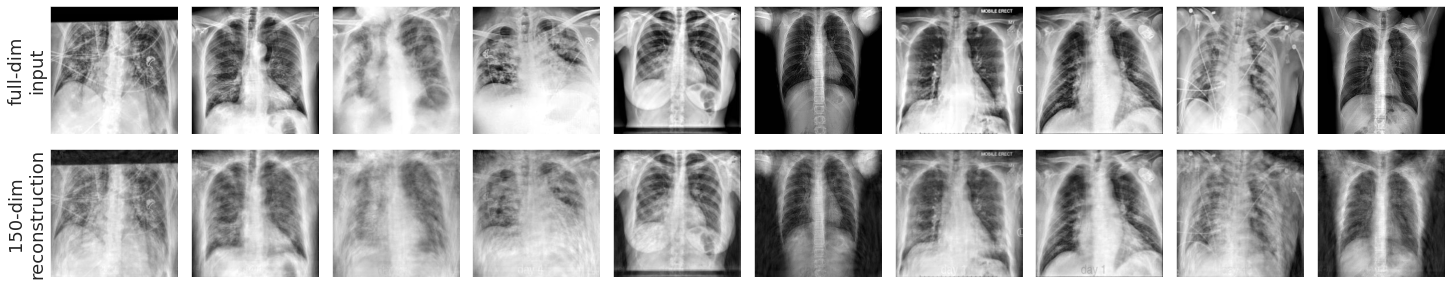

In [ ]:
#=======================================
#DIMENSIONAL RECONSTRUCTED OUTPUT PLOT
#=======================================
fig, ax = plt.subplots(2, 10, figsize=(25, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(X[i].reshape(224,224), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(224, 224), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput', fontsize=18)
ax[1, 0].set_ylabel('150-dim\nreconstruction',fontsize=18)

A comparison between the full dimensional input and the 150 dimensional reconstructed output

# Bayesian Optimization (Adjusted Bounds)

Example of Bayesian Hyperparameter Optimization (Third Step)

> Bounds:
*   Rotation: 68.28 degrees – 240.41 degrees 
*   Zoom: 0.34 – 0.37 
*   Width shift: 0.19 – 0.35 
*   Height Shift: -0.13 – 0.15 
*   Horizontal Flip: True (1) – False (0)
*   Vertical Flip: True (1) - False (0) 
*   Learning Rate: 0.0003,0.00025499994606093326
*   Batch Size: 2, 3 
*   Kernel Size: 1,3 
*   Epochs: 200-300 

Minimized loss: 0.10662011057138443 

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from keras.layers import Activation, Dropout, BatchNormalization, Dense
from keras.metrics import categorical_crossentropy
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import pandas as pds
import random
import time

In [ ]:
#HELPFUL RESOURCES:
#https://towardsdatascience.com/bayesian-hyper-parameter-optimization-neural-networks-tensorflow-facies-prediction-example-f9c48d21f795
#https://github.com/shibuiwilliam/keras_gpyopt/blob/master/bopt_nn.ipynb
#https://github.com/toantm/keras-bda/blob/master/da_lenet5_mnist.py
#https://www.blopig.com/blog/wp-content/uploads/2019/10/GPyOpt-Tutorial1.html
#https://nanonets.com/blog/hyperparameter-optimization/ Optimizacion de hiperparametros 
trainingsetDA= np.reshape(projected, (294, 224, 224,1)) #Input reshape 2D -> 3D

In [ ]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor: 
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2), 
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out


In [ ]:

class RESNET(): 
    def __init__(self,
                adam_lr=0.00025499994606093326,
                rotation_range = 64.286432593714,
                zoom_range = 0.34062544049205, 
                width_shift_range=0.35701543762784316,  
                height_shift_range=-0.13225810817769346,  
                horizontal_flip = True,  
                vertical_flip=False,
                batch_size=1, 
                epochs=200,
                kernel_size=3): 

        self.adam_lr = adam_lr 
        self.rotation_range = rotation_range 
        self.zoom_range = zoom_range
        self.width_shift_range=width_shift_range 
        self.height_shift_range=height_shift_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip= vertical_flip  
        self.batch_size = batch_size
        self.epochs = epochs
        self.kernel_size = kernel_size
        self.__datagen = self.data_augmentation()
        self.__model = self.resnet_model()
        

    def residual_block(self, x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor: 
        y = Conv2D(kernel_size=kernel_size,
                   strides= (1 if not downsample else 2), 
                   filters=filters,
                   padding="same")(x) 
        y = relu_bn(y)
        y = Conv2D(kernel_size=self.kernel_size,
                   strides=1,
                   filters=filters,
                   padding="same")(y)
                   
        if downsample:
            x = Conv2D(kernel_size=self.kernel_size,
                     strides=2,
                     filters=filters,
                     padding="same")(x)
        out = Add()([x, y])
        out = relu_bn(out)
        return out

    # resnet model
    def resnet_model(self):
        inputs = Input(shape=(224,224, 1))
        num_filters = 64 
        t = BatchNormalization()(inputs)
        t = Conv2D(kernel_size= self.kernel_size , strides= 1, filters=num_filters, padding="same")(t)
        t = relu_bn(t)
        num_blocks_list = [2, 5, 5, 2]
        for i in range(len(num_blocks_list)):
          num_blocks = num_blocks_list[i]
          for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
        t = AveragePooling2D(4)(t)
        t = Flatten()(t)
        outputs = Dense(3, activation='softmax')(t)
    
        model = Model(inputs, outputs)

        model.compile(optimizer=Adam(learning_rate=self.adam_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def data_augmentation(self):
        datagen = ImageDataGenerator(
        rotation_range =self.rotation_range,  
        zoom_range = self.zoom_range, 
        width_shift_range= self.width_shift_range, 
        height_shift_range= self.height_shift_range,  
        horizontal_flip =self.horizontal_flip, 
        vertical_flip=self.vertical_flip) 
        datagen.fit(trainingsetDA)
        return datagen


    def resnet_fit(self):
        early_stopping = EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
        history = self.__model.fit(self.__datagen.flow(trainingsetDA,y_train, batch_size=self.batch_size),
                            epochs=self.epochs,verbose=1, validation_data=(x_val, y_val),
                            callbacks=[early_stopping])
    

    def resnet_evaluate(self):
        self.resnet_fit()
        evaluation = self.__model.evaluate(x_val,y_val, batch_size=self.batch_size, verbose=0)
        return evaluation



In [ ]:
#RUN RESNET CLASS
def run_RESNET (adam_lr=0.00025499994606093326,
                rotation_range = 64.286432593714, 
                zoom_range = 0.34062544049205,
                width_shift_range=0.35701543762784316, 
                height_shift_range=-0.13225810817769346,  
                horizontal_flip = True, 
                vertical_flip=False, 
                batch_size=1, 
                epochs=200,
                kernel_size=3):
               
    _resnet = RESNET(adam_lr = adam_lr,
                     rotation_range = rotation_range,  
                     zoom_range = zoom_range,  
                     width_shift_range=width_shift_range,  
                     height_shift_range=height_shift_range,  
                     horizontal_flip = horizontal_flip,  
                     vertical_flip= vertical_flip,
                     batch_size = batch_size,
                     epochs = epochs,
                     kernel_size = kernel_size)
    resnet_evaluation = _resnet.resnet_evaluate()
    return resnet_evaluation

In [ ]:
bounds = [{'name': 'adam_lr',    'type': 'continuous',    'domain': (0.0003,0.00025499994606093326)},    
          {'name': 'rotation_range',                         'type': 'continuous',    'domain': (64.286432593714, 240.4145242612962)}, 
          {'name': 'zoom_range',                             'type': 'continuous',    'domain': (0.34062544049205,0.3699951353726556)}, 
          {'name': 'width_shift_range',                      'type': 'continuous',    'domain': (0.35701543762784316,0.1909674923332263)},
          {'name': 'height_shift_range',                     'type': 'continuous',    'domain': (-0.13225810817769346,0.15691914435536908)},
          {'name': 'horizontal_flip',                        'type': 'categorical',   'domain': (True, False)},
          {'name': 'vertical_flip',                          'type': 'categorical',   'domain': (True, False)},
          {'name': 'batch_size',       'type': 'discrete',    'domain': (2, 3)},
          {'name': 'epochs',           'type': 'discrete',    'domain': (200,250)}, 
          {'name': 'kernel',           'type': 'discrete',    'domain': (1,3)}]

In [ ]:
def f(x):
    print(x)
    evaluation = run_RESNET(
        adam_lr = float(x[:,0]),
        rotation_range = int(x[:,1]),
        zoom_range = float(x[:,2]),
        width_shift_range = float(x[:,3]),
        height_shift_range = float(x[:,4]),
        horizontal_flip = 1, #int(x[:,5]),
        vertical_flip = int(x[:,6]),
        batch_size = int(x[:,7]), 
        epochs = 200, # int(x[:,8]), 
        kernel_size = int(x[:,9]),
        )
    
    print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0], evaluation[1]))
    print(evaluation)
    return evaluation[0]

Streaming output truncated to the last 5000 lines.
Epoch 41/200
98/98 [==============================] - 6s 62ms/step - loss: 0.7900 - accuracy: 0.6478 - val_loss: 0.6166 - val_accuracy: 0.7460
Epoch 42/200
98/98 [==============================] - 6s 62ms/step - loss: 0.6578 - accuracy: 0.7204 - val_loss: 1.1139 - val_accuracy: 0.6032
Epoch 43/200
98/98 [==============================] - 6s 62ms/step - loss: 0.6501 - accuracy: 0.6705 - val_loss: 0.6390 - val_accuracy: 0.6984
Epoch 44/200
98/98 [==============================] - 6s 63ms/step - loss: 0.7213 - accuracy: 0.6985 - val_loss: 0.7094 - val_accuracy: 0.6667
Epoch 45/200
98/98 [==============================] - 6s 62ms/step - loss: 0.8198 - accuracy: 0.6260 - val_loss: 0.3146 - val_accuracy: 0.8889
Epoch 46/200
98/98 [==============================] - 6s 62ms/step - loss: 0.7853 - accuracy: 0.6175 - val_loss: 0.5185 - val_accuracy: 0.7460
Epoch 47/200
98/98 [==============================] - 6s 62ms/step - loss: 0.7722 - accurac

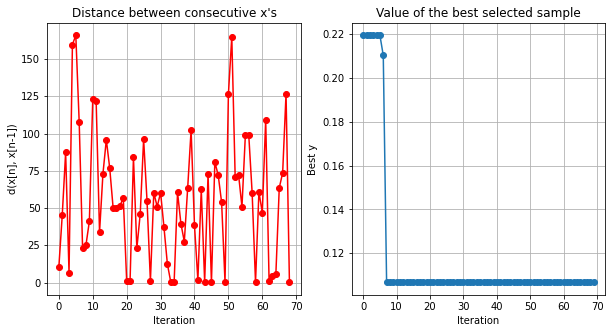

In [ ]:
inicio = time.time()

opt_resnet = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, initial_design_numdata= 20, Initial_design_numdata='latin')
BayesianOpt = opt_resnet.run_optimization(max_iter=50)
opt_resnet.save_evaluations("ev_file_adjusted_bounds")

print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
\t{18}:\t{19}
""".format(bounds[0]["name"],opt_resnet.x_opt[0],
           bounds[1]["name"],opt_resnet.x_opt[1],
           bounds[2]["name"],opt_resnet.x_opt[2],
           bounds[3]["name"],opt_resnet.x_opt[3],
           bounds[4]["name"],opt_resnet.x_opt[4],
           bounds[5]["name"],opt_resnet.x_opt[5],
           bounds[6]["name"],opt_resnet.x_opt[6],
           bounds[7]["name"],opt_resnet.x_opt[7],
           bounds[8]["name"],opt_resnet.x_opt[8],
           bounds[9]["name"],opt_resnet.x_opt[9]))
print("optimized loss: {0}".format(opt_resnet.fx_opt))

fin = time.time()
print(fin-inicio)
opt_resnet.plot_convergence(BayesianOpt)

#  

# Data augmentation (Optimal Hyperparameters)
	adam_lr:	0.0002587553425186625
	rotation_range:	187.49378124047175
	zoom_range:	0.3697637281275463
	width_shift_range:	0.22761251887707423
	height_shift_range:	-0.12297965119856483
	horizontal_flip:	1.0
	vertical_flip:	0.0
	batch_size:	3.0
	epochs:	200.0
	kernel:	1.0


In [ ]:
#===========================
#TRAINING AND TESTING SHAPES
#===========================

x_train= np.reshape(x_train_normalized, (294, 224, 224,1))
x_test= np.reshape(x_test, (63, 224, 224,1))

#Training
print('x_train set shape>>>>',x_train.shape)
print('y_train set shape>>>>',y_train.shape)

#Testing
print('x_test set shape>>>>',x_test.shape)
print('y_test set shape>>>>',y_test.shape)

x_train set shape>>>> (294, 224, 224, 1)
y_train set shape>>>> (294,)
x_test set shape>>>> (63, 224, 224, 1)
y_test set shape>>>> (63,)


In [ ]:
#==========================================================
#DATA AUGMENTATION OPERATIONS WITH OPTIMAL HYPERPARAMETERS 
#==========================================================
datagen = ImageDataGenerator(
        rotation_range = 187.49378124047175, 
        zoom_range = 0.3697637281275463,  
        width_shift_range= 0.22761251887707423,  
        height_shift_range= -0.12297965119856483, 
        horizontal_flip = True,  
        vertical_flip=False)  

dgf=datagen.fit(x_train)

#Residual Neural Network (Optimal Hyperparameters)


In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from keras.layers import Activation, Dropout, BatchNormalization, Dense
from keras.metrics import categorical_crossentropy
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
import pandas as pds
import random
import time

#### MODEL OPTIMIZED HYPERPARAMETERS #####
adam_lr= 0.0002587553425186625          #
batch_size=3                             #
epochs=200                               #
##########################################


def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor: 
    y = Conv2D(kernel_size= 1, 
               strides= (1 if not downsample else 2), 
               filters=filters,
               padding="same")(x) 
    y = relu_bn(y)
    y = Conv2D(kernel_size= 3, 
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out
  

def create_res_net():
    
    inputs = Input(shape=(224,224,1))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=1,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(3, activation='softmax')(t)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=adam_lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


    

In [ ]:
#=========
#ResNet
#========
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import datetime
import time
inicio = time.time() 

(x_train, y_train), (x_test, y_test) = (x_train,y_train),(x_test, y_test)

model = create_res_net()  #ResNet
model.summary()

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
name = 'RESNET'+timestr 



#######################################MODEL CHECKPOINTS ###########################################################
checkpoint_path = "/content/Weigths"+name+"/_weights.{epoch:02d}-{val_loss:.2f}.hdf5" 
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    filepath= checkpoint_path ,save_weights_only=True, monitor='val_loss',mode='min',
     verbose=0, save_best_only=True  # will show you nothing (silent), solo se almacenan los mejores resultados
)
#####################################################################################################################


tensorboard_callback = TensorBoard(
    log_dir='tensorboard_logs/'+name,
    histogram_freq=1
)


early_stopping = EarlyStopping(patience=200, verbose=1,restore_best_weights=True)
history = model.fit(datagen.flow(
    x=x_train,
    y=y_train, batch_size=batch_size),
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    
    callbacks=[early_stopping, cp_callback, tensorboard_callback]
)
fin = time.time()
print('Compilation time in seconds >>>> ', fin-inicio)    

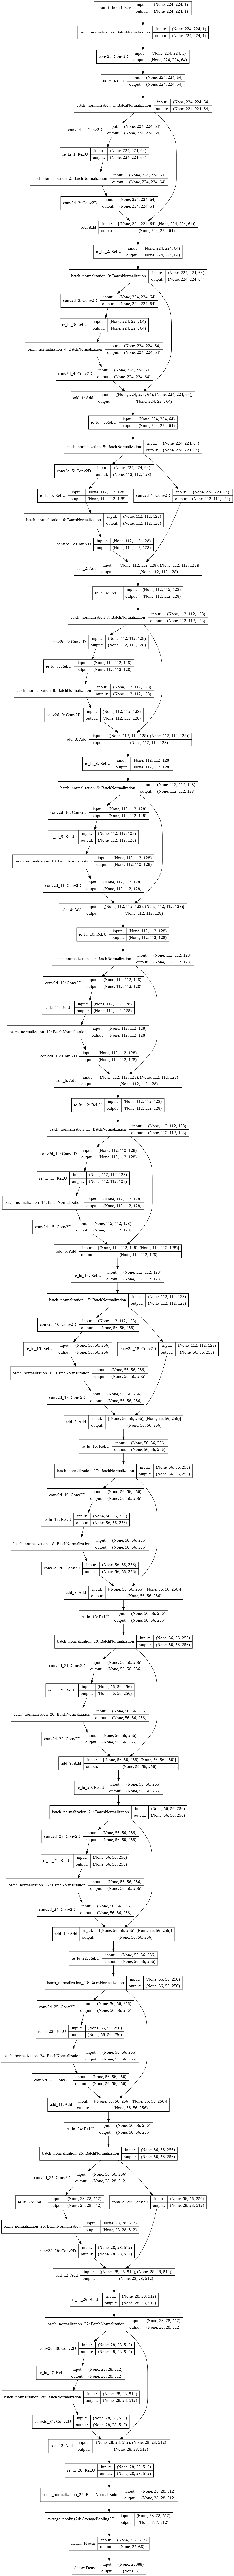

In [ ]:
#==============
#ResNet Summary
#==============
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    #show_2type=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
#==========================
#LOADING BEST MODEL WEIGTHS
#==========================
bw_path='/content/WeigthsRESNET20210510-204850/_weights.207-0.19.hdf5'
model.load_weights(bw_path)

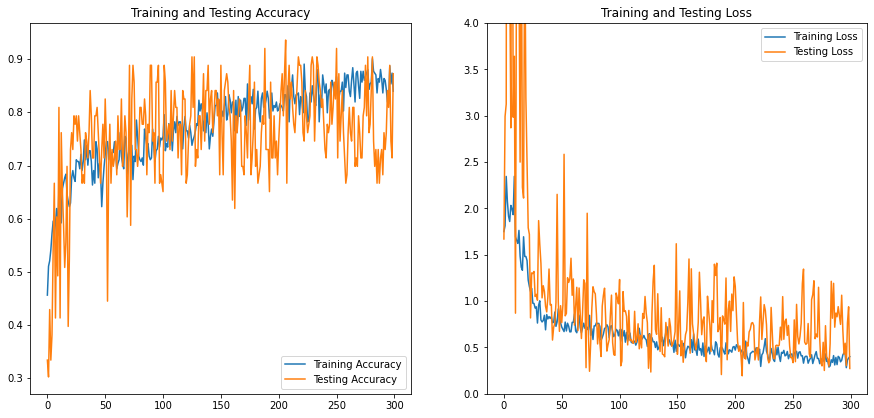

In [ ]:
#==============================
#TRAINING ANS TESTING ACCURACY
#==============================

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(300)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')


#==============================
#TRAINING ANS TESTING LOSS
#==============================

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.ylim([0, 4])
plt.show()

In [ ]:
#==============================
#MODEL METRICS
#==============================
predict_prob=model.predict([x_test])
predict_classes=np.argmax(predict_prob,axis=1)
predictions = predict_classes.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Covid (Class 0)','Normal (Class 1)','Pneumonia(Class 2)']))

                    precision    recall  f1-score   support

   Covid (Class 0)       0.84      1.00      0.91        21
  Normal (Class 1)       1.00      1.00      1.00        21
Pneumonia(Class 2)       1.00      0.81      0.89        21

          accuracy                           0.94        63
         macro avg       0.95      0.94      0.94        63
      weighted avg       0.95      0.94      0.94        63



In [ ]:
#==============================
#MODEL PREDICTIONS
#==============================
print(predict_prob.shape)
print(predictions)
print(y_val)

(63, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 2 0 2 0 2 0 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
